# **Q2. Image Classification programming** 

### **2.1 Dataset build**

In [16]:
import cv2
import glob

# Resizing datasets
def resize_images(directory, size):
    images = glob.glob(directory + "/*.jpg")
    for img in images:
        image = cv2.imread(img)
        resized_img = cv2.resize(image, size)
        cv2.imwrite(img, resized_img)

# Image directories
directories = [r'C:\Users\ASUS\Documents\DTS101CW\Datasets\apples',
               r'C:\Users\ASUS\Documents\DTS101CW\Datasets\oranges']

# Resize to 128 x 128 pixels
resize_to = (128, 128)

# Call function
for directory in directories:
    resize_images(directory, resize_to)


### **2.2 Data loading**

Randomly spliting the dataset into 80 images training set, 20 images validation set and 20 images test set. Display the number of data entries, the number of classes, the number of data entries for each classes, and the shape of the image size. Randomly plot 10 images in the training set with their corresponding labels.


In [17]:
import torch
import numpy as np
import random 
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
from torch.utils.data import DataLoader, random_split
from torch.utils.data import DataLoader


# Define transformations
transform = transforms.Compose([ 
    transforms.ToTensor(),          # Convert images to PyTorch tensors
])

# Load dataset
# C:\Users\ASUS\Documents\DTS101CW\Datasets
dataset = datasets.ImageFolder(root= r'C:\Users\ASUS\Documents\DTS101CW\Datasets', transform=transform)

# Split dataset
training_size = 80
validation_size = 20
test_size = 20

# Make sure the total datasets equal to 120
assert training_size + validation_size + test_size == len(dataset)

# Randomly split the dataset
training_set, validation_set, test_set = random_split(dataset, [training_size, validation_size, test_size])

# Create Dataloaders
training_loader = DataLoader(training_set, batch_size= 32, shuffle=True)
validation_loader = DataLoader(validation_set, batch_size= 20, shuffle=True)
test_loader = DataLoader(test_set, batch_size= 20, shuffle=True)


Displaying the number of data entries, the number of classes, the number of data entries for each classes, and the shape of the image size. Randomly plot 10 images in the training set with their corresponding labels.


Number of data entries in the training set: 80
Number of classes: 2
Number of data entries per class: {'apples': 38, 'oranges': 42}
Image size: torch.Size([3, 128, 128])


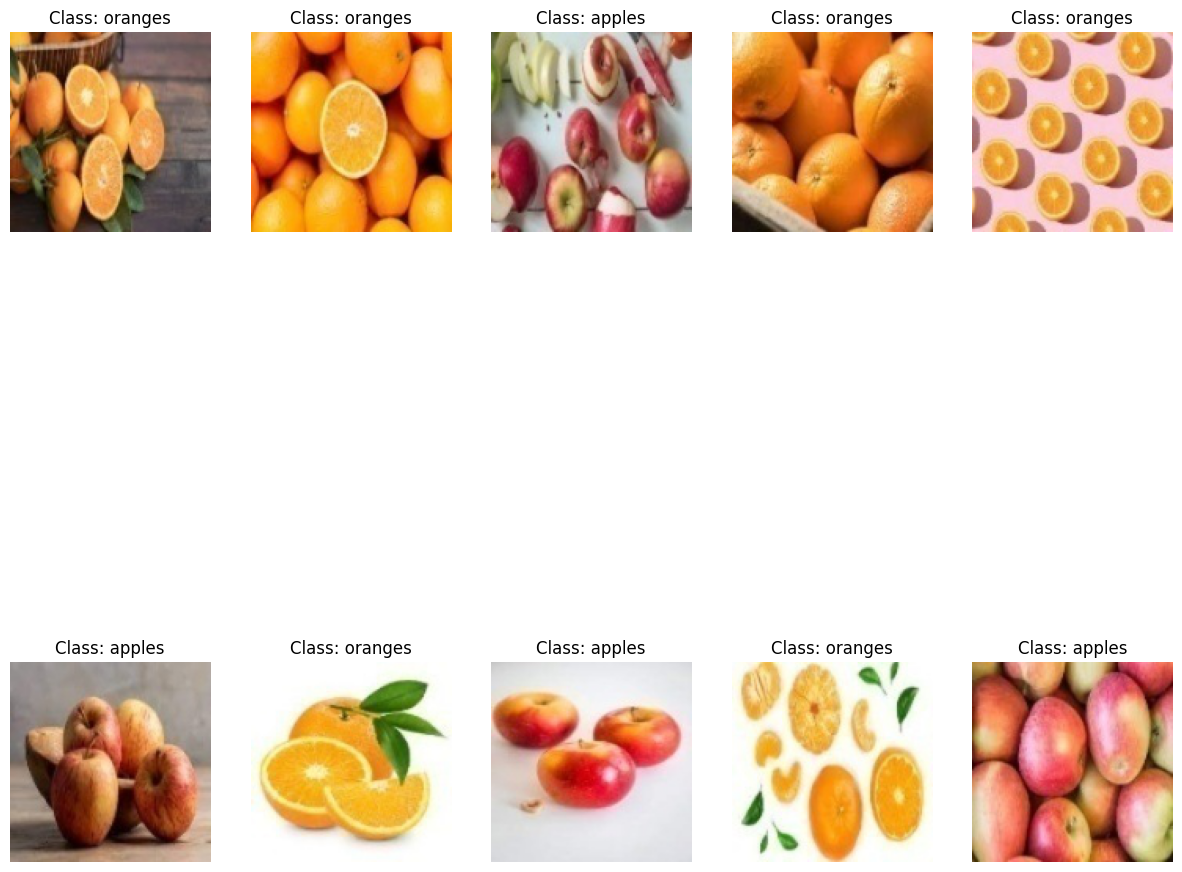

In [18]:
# Number of data entries
print(f"Number of data entries in the training set: {len(training_set)}")

# Number of classes
print(f"Number of classes: {len(dataset.classes)}")

# Number of data entries per class
class_counts = {}
for _, index in training_set:
    label = dataset.classes[index]
    class_counts[label] = class_counts.get(label, 0) + 1
print(f"Number of data entries per class: {class_counts}")

# Display image size
image, _ = training_set[0]
print(f"Image size: {image.shape}")

# Plotting random images from dataset
img_display = 10
random_indices = random.sample(range(len(training_set)), img_display)

# Display the images
plt.figure(figsize=(15, 15))
for i, idx in enumerate(random_indices):
    image, label = training_set[idx]
    plt.subplot(2, 5, i + 1) 
    plt.imshow(image.permute(1, 2, 0))  
    plt.title(f"Class: {dataset.classes[label]}")
    plt.axis('off')

plt.show()

### **2.3 Convolutional Network Model Build**

In [19]:
import torch.nn as nn
import torch.nn.functional as F

class Network(nn.Module):
    def __init__(self, num_classes=2):
        super(Network, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=5, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(in_channels=5, out_channels=10, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(10 * 32 * 32, 100)
        self.fc2 = nn.Linear(100, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        print(x.shape)
        x = x.view(-1, 10 * 32 * 32)
        x = self.fc1(x)
        x = self.fc2(x)
        return x
        
model = Network ()
print (model)

Network(
  (conv1): Conv2d(3, 5, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(5, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=10240, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=2, bias=True)
)


### **2.4 Training**

In [20]:
import torch.optim as optim

#Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [21]:
# Create empty lists for losses and accuracies
training_losses = []
validation_losses = []
training_accuracies = []
validation_accuracies = []

# Training loop
for epoch in range(50):  # Train for at least 50 epochs
    model.train()
    total_correct = 0
    total_samples = 0
    for batch_idx, (data, target) in enumerate(training_loader):
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        training_losses.append(loss.item())  # Append training loss

        # Calculating training accuracy
        _, predicted = output.max(1)
        total_samples += target.size(0)
        total_correct += (predicted == target).sum().item()
    training_accuracy = 100 * total_correct / total_samples
    training_accuracies.append(training_accuracy) 

    
    # Calculating validation accuracy
    model.eval()
    validation_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in validation_loader:
            output = model(data)
            validation_loss += criterion(output, target).item()
            _, predicted = output.max(1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
        validation_losses.append(validation_loss / len(validation_loader)) 
        validation_accuracy = 100 * correct / total
        validation_accuracies.append(validation_accuracy)  

    print(f"Training finished")
    print(f"Epoch [{epoch+1}/50], Loss: {loss.item()}, Training Accuracy: {training_accuracy:.2f}%, Validation Accuracy: {validation_accuracy:.2f}%")

torch.Size([32, 10, 32, 32])
torch.Size([32, 10, 32, 32])
torch.Size([16, 10, 32, 32])
torch.Size([20, 10, 32, 32])
Training finished
Epoch [1/50], Loss: 2.551718235015869, Training Accuracy: 43.75%, Validation Accuracy: 45.00%
torch.Size([32, 10, 32, 32])
torch.Size([32, 10, 32, 32])
torch.Size([16, 10, 32, 32])
torch.Size([20, 10, 32, 32])
Training finished
Epoch [2/50], Loss: 3.0642685890197754, Training Accuracy: 52.50%, Validation Accuracy: 45.00%
torch.Size([32, 10, 32, 32])
torch.Size([32, 10, 32, 32])
torch.Size([16, 10, 32, 32])
torch.Size([20, 10, 32, 32])
Training finished
Epoch [3/50], Loss: 0.6117197871208191, Training Accuracy: 55.00%, Validation Accuracy: 55.00%
torch.Size([32, 10, 32, 32])
torch.Size([32, 10, 32, 32])
torch.Size([16, 10, 32, 32])
torch.Size([20, 10, 32, 32])
Training finished
Epoch [4/50], Loss: 1.3675205707550049, Training Accuracy: 47.50%, Validation Accuracy: 55.00%
torch.Size([32, 10, 32, 32])
torch.Size([32, 10, 32, 32])
torch.Size([16, 10, 32, 32]

Plot the training history, e.g., produce two graphs (one for training and validation losses, one for training and validation accuracy) that each contains 2 curves. 

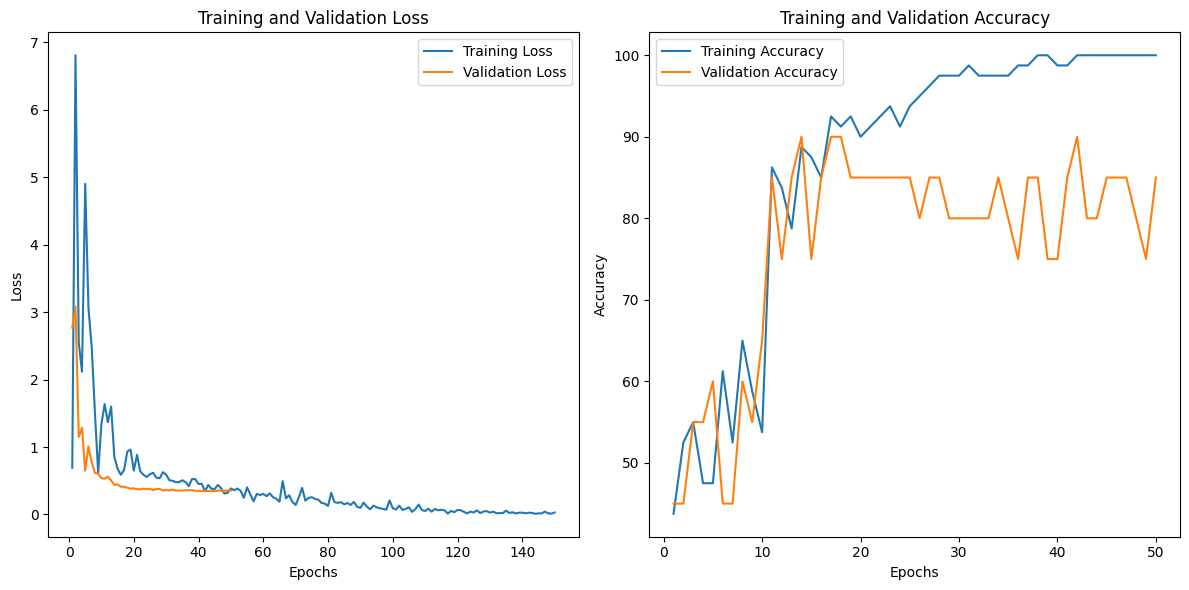

In [22]:
# Plot training and validation losses
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(1, len(training_losses) + 1), training_losses, label='Training Loss')
plt.plot(range(1, len(validation_losses) + 1), validation_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot training and validation accuracies
plt.subplot(1, 2, 2)
plt.plot(range(1, len(training_accuracies) + 1), training_accuracies, label='Training Accuracy')
plt.plot(range(1, len(validation_accuracies) + 1), validation_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

### **2.5 Testing**

Test the trained model on the test set. Show the accuracy and confusion matrix using python commands.

torch.Size([20, 10, 32, 32])
Test Accuracy: 90.00%


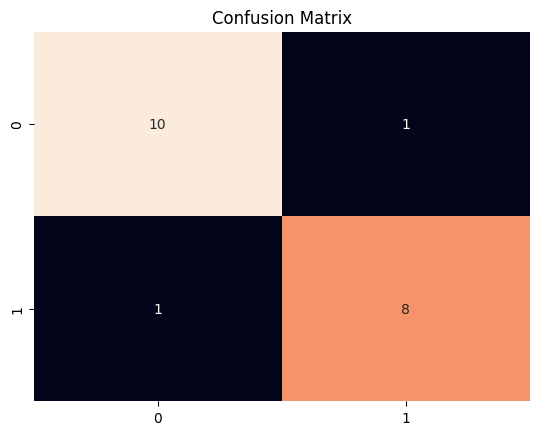

In [23]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Initialize empty lists
y_true = []
y_pred = []

# Testing
# Computing predictions 
with torch.no_grad():
    for data, target in test_loader:
        output = model(data)
        _, predicted = output.max(1)
        y_true.extend(target.tolist())
        y_pred.extend(predicted.tolist())

# Calculate the test accuracy
test_correct = sum(pred == true for pred, true in zip(y_pred, y_true))
test_total = len(y_true)
test_accuracy = 100 * test_correct / test_total

print(f"Test Accuracy: {test_accuracy:.2f}%")

# Create confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Print confusion matrix
sns.heatmap(cm, annot=True, fmt="d", cbar=False)
plt.title("Confusion Matrix")
plt.show()